In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler
import dmba
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline

In [2]:
allianz_df=pd.read_excel('Allianz.xlsx',sheet_name='AllianzDisabilityClaimDataset')

In [3]:
allianz_df.head()

,Contract_number,Sex,Birth_year,Birth_month,End_age,Claim_year,Claim_month,Pct_dis1,Pct_dis2,Pct_dis3,...,Pct_dis17,Pct_dis18,Pct_dis19,Pct_dis20,Pct_dis21,Duration,Postalcode,District,Broker,Annuity
0,42142935,1,1952,7,65,2004,6,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,12,1000,Brussels,NaN,9.648783e+09
1,42142935,1,1952,7,65,2012,11,0.8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,6800,Luxembourg,NaN,9.578540e+03
2,71384115,1,1951,8,65,2008,7,0.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,6860,Luxembourg,NaN,1.298077e+04
3,12246809,1,1953,8,65,2008,7,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,10,4140,Liege,27531419.0,9.785032e+06
4,14280764,2,1960,3,65,2016,1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,3000,Vlaams Brabant,58473276.0,3.434563e+04


In [4]:
# Calculate the number of missing values in each column
missing_values = allianz_df.isnull().sum()

# Display the result
print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
Contract_number      0
Sex                  0
Birth_year           0
Birth_month          0
End_age              0
Claim_year           0
Claim_month          0
Pct_dis1             0
Pct_dis2             0
Pct_dis3             0
Pct_dis4             0
Pct_dis5             0
Pct_dis6             0
Pct_dis7             0
Pct_dis8             0
Pct_dis9             0
Pct_dis10            0
Pct_dis11            0
Pct_dis12            0
Pct_dis13            0
Pct_dis14            0
Pct_dis15            0
Pct_dis16            0
Pct_dis17            0
Pct_dis18            0
Pct_dis19            0
Pct_dis20            0
Pct_dis21            0
Duration             0
Postalcode           0
District             0
Broker             432
Annuity              0
dtype: int64


In [5]:
# Find unique brokers and their occurrences
broker_counts = allianz_df['Broker'].value_counts(dropna=False)

# Display the unique brokers and their counts
print("Unique brokers and their occurrences:")
print(broker_counts.head())

Unique brokers and their occurrences:
Broker
NaN           432
70075182.0     88
32704839.0     88
71731179.0     78
79779951.0     76
Name: count, dtype: int64


In [6]:
# Group by 'District' and count the missing values in the 'Broker' column
missing_broker_by_district = allianz_df.groupby('District')['Broker'].apply(lambda x: x.isnull().sum())

# Calculate the total number of entries for each district
total_by_district = allianz_df.groupby('District')['Broker'].count()

# Calculate the percentage of missing brokers in each district
missing_percentage_by_district = (missing_broker_by_district / (total_by_district + missing_broker_by_district)) * 100

# Combine the results into a DataFrame for better clarity
district_missing_data = pd.DataFrame({
    'Missing Brokers': missing_broker_by_district,
    'Total Entries': total_by_district + missing_broker_by_district,
    'Missing Percentage': missing_percentage_by_district
})

# Display the result
print(district_missing_data)

                 Missing Brokers  Total Entries  Missing Percentage
District                                                           
Antwerpen                     45            465            9.677419
Brabant Wallon                16            152           10.526316
Brussels                      14            318            4.402516
Hainaut                       51            650            7.846154
Liege                         58            895            6.480447
Limburg                       85            830           10.240964
Luxembourg                    18            251            7.171315
Namur                         18            286            6.293706
Oost-Vlaanderen               46            474            9.704641
Vlaams Brabant                24            284            8.450704
West-Vlaanderen               57            765            7.450980


In [7]:
# Group by 'District' and 'Broker', then count the number of occurrences
district_broker_counts = allianz_df.groupby(['District', 'Broker']).size().reset_index(name='Count')

# Sort by 'District' and 'Count' in descending order, then get the top 5 brokers per district
top_brokers_per_district = district_broker_counts.sort_values(by=['District', 'Count'], ascending=[True, False])
top_brokers_per_district = top_brokers_per_district.groupby('District').head(5)

# Calculate the percentage share of each broker in each district
top_brokers_per_district['Customer Share (%)'] = (top_brokers_per_district['Count'] / 
                                                   top_brokers_per_district.groupby('District')['Count'].transform('sum')) * 100

# Display the result
print("Top 5 Brokers per District and their Customer Share:")
print(top_brokers_per_district[['District', 'Broker', 'Count', 'Customer Share (%)']])

Top 5 Brokers per District and their Customer Share:
             District      Broker  Count  Customer Share (%)
26          Antwerpen  21206979.0     55           40.740741
142         Antwerpen  98669561.0     37           27.407407
85          Antwerpen  63356854.0     18           13.333333
29          Antwerpen  28055037.0     14           10.370370
11          Antwerpen   6909628.0     11            8.148148
159    Brabant Wallon  20078041.0      6           24.000000
212    Brabant Wallon  76063886.0      6           24.000000
172    Brabant Wallon  36525560.0      5           20.000000
149    Brabant Wallon   7628801.0      4           16.000000
165    Brabant Wallon  29789900.0      4           16.000000
260          Brussels  19193564.0     10           20.408163
263          Brussels  20078041.0     10           20.408163
338          Brussels  70075182.0     10           20.408163
341          Brussels  71731179.0     10           20.408163
243          Brussels   5559985.

In [8]:
# Group by 'Broker' and 'District', then count the number of occurrences
broker_district_counts = allianz_df.groupby(['Broker', 'District']).size().reset_index(name='Count')

# Sort by 'Broker' and 'Count' in descending order, so that the most popular brokers are on top
broker_district_counts = broker_district_counts.sort_values(by=['Broker', 'Count'], ascending=[True, False])

# Get the top 2 districts for each broker
top_2_districts_per_broker = broker_district_counts.groupby('Broker').head(2)

# Display the result
print("Top 2 Districts for Each Broker (Starting from Most Popular Broker):")
print(top_2_districts_per_broker[['Broker', 'District', 'Count']])

Top 2 Districts for Each Broker (Starting from Most Popular Broker):
          Broker         District  Count
0        79495.0         Brussels      2
1        97321.0  Oost-Vlaanderen      2
2       147279.0          Limburg     36
3       154246.0        Antwerpen      2
5       164931.0       Luxembourg      3
...          ...              ...    ...
1660  99768249.0            Liege     13
1661  99925253.0  Oost-Vlaanderen      4
1662  99925253.0  West-Vlaanderen      1
1663  99946760.0          Limburg      4
1664  99980375.0         Brussels      1

[1548 rows x 3 columns]


In [9]:
# Group by 'Broker' and 'District', then count the number of occurrences
broker_district_counts = allianz_df.groupby(['Broker', 'District']).size().reset_index(name='Count')

# Sort by 'Count' in descending order, then by 'Broker' to ensure brokers are sorted by customer count
broker_district_counts = broker_district_counts.sort_values(by=['Count', 'Broker'], ascending=[False, True])

# Get the top 2 districts for each broker, ordered by count
top_2_districts_per_broker = broker_district_counts.groupby('Broker').head(2)

# Display the result
print("Top 2 Districts for Each Broker (Sorted by Customer Count):")
print(top_2_districts_per_broker[['Broker', 'District', 'Count']].head(60))

Top 2 Districts for Each Broker (Sorted by Customer Count):
          Broker         District  Count
501   32704839.0          Limburg     85
995   61603288.0          Limburg     69
88     5614684.0          Limburg     67
334   21206979.0        Antwerpen     55
1395  84457806.0            Liege     51
1319  79779951.0  West-Vlaanderen     42
540   35437116.0          Limburg     40
977   60246561.0            Liege     38
1642  98669561.0        Antwerpen     37
2       147279.0          Limburg     36
722   45371028.0  Oost-Vlaanderen     34
858   52871726.0  West-Vlaanderen     34
640   40941981.0            Liege     32
1309  79010023.0  Oost-Vlaanderen     31
1025  64085937.0  West-Vlaanderen     28
782   48944328.0            Liege     27
1570  93602112.0  West-Vlaanderen     27
1247  76082078.0            Liege     26
61     4138310.0            Liege     23
764   47895935.0       Luxembourg     23
139    9346475.0            Liege     22
169   11260080.0  West-Vlaanderen     

In [10]:
# Filter the rows where 'Broker' is missing
missing_broker_df = allianz_df[allianz_df['Broker'].isna()]

# Calculate the average and median of 'Duration' for those rows
average_duration = missing_broker_df['Duration'].mean()
median_duration = missing_broker_df['Duration'].median()

# Display the results
print(f"Average Duration for records with missing 'Broker': {average_duration}")
print(f"Median Duration for records with missing 'Broker': {median_duration}")

Average Duration for records with missing 'Broker': 2.486111111111111
Median Duration for records with missing 'Broker': 1.0


In [11]:
# Drop rows where 'Broker' is missing
allianz_df = allianz_df.dropna(subset=['Broker'])

In [12]:
allianz_df.columns

Index(['Contract_number', 'Sex', 'Birth_year', 'Birth_month', 'End_age',
       'Claim_year', 'Claim_month', 'Pct_dis1', 'Pct_dis2', 'Pct_dis3',
       'Pct_dis4', 'Pct_dis5', 'Pct_dis6', 'Pct_dis7', 'Pct_dis8', 'Pct_dis9',
       'Pct_dis10', 'Pct_dis11', 'Pct_dis12', 'Pct_dis13', 'Pct_dis14',
       'Pct_dis15', 'Pct_dis16', 'Pct_dis17', 'Pct_dis18', 'Pct_dis19',
       'Pct_dis20', 'Pct_dis21', 'Duration', 'Postalcode', 'District',
       'Broker', 'Annuity'],
      dtype='object')

In [13]:
# Filter data for long-duration claims
long_duration = allianz_df[allianz_df['Duration'] > 10]

# Calculate the total number of clients per broker
total_clients_per_broker = allianz_df['Broker'].value_counts()

# Calculate the number of long-duration clients per broker
long_duration_clients_per_broker = long_duration['Broker'].value_counts()

# Compute the percentage of long-duration clients for each broker
long_duration_percentage = (long_duration_clients_per_broker / total_clients_per_broker) * 100

# Convert to DataFrame for better readability
long_duration_percentage_df = long_duration_percentage.reset_index()
long_duration_percentage_df.columns = ['Broker', 'Long_Duration_Percentage']

# Sort by percentage in descending order
long_duration_percentage_df = long_duration_percentage_df.sort_values(by='Long_Duration_Percentage', ascending=False)

# Display the top 10 brokers (optional)
print(long_duration_percentage_df.head(10))

         Broker  Long_Duration_Percentage
357  29769803.0                     100.0
919  70152678.0                     100.0
460  37148928.0                     100.0
459  37123338.0                     100.0
458  36936199.0                     100.0
902  69024757.0                     100.0
911  69670985.0                     100.0
450  36340774.0                     100.0
447  36184231.0                     100.0
424  34092712.0                     100.0


In [14]:
# Filter data for long-duration claims
long_duration = allianz_df[allianz_df['Duration'] > 12]

# Calculate the total number of clients per broker
total_clients_per_broker = allianz_df['Broker'].value_counts()

# Calculate the number of long-duration clients per broker
long_duration_clients_per_broker = long_duration['Broker'].value_counts()

# Create a DataFrame with both counts and percentage
broker_analysis_df = pd.DataFrame({
    'Total_Clients': total_clients_per_broker,
    'Long_Duration_Clients': long_duration_clients_per_broker,
})

# Fill NaN values with 0 for brokers with no long-duration clients
broker_analysis_df.fillna(0, inplace=True)

# Add percentage of long-duration claims
broker_analysis_df['Long_Duration_Percentage'] = (
    broker_analysis_df['Long_Duration_Clients'] / broker_analysis_df['Total_Clients'] * 100
)

# Reset index and rename columns for clarity
broker_analysis_df.reset_index(inplace=True)
broker_analysis_df.rename(columns={'index': 'Broker'}, inplace=True)

# Sort by total number of clients in descending order
broker_analysis_df = broker_analysis_df.sort_values(by='Total_Clients', ascending=False)

# Display the top 10 brokers (optional)
print(broker_analysis_df.head(50))


          Broker  Total_Clients  Long_Duration_Clients  \
400   32704839.0             88                   10.0   
917   70075182.0             88                   27.0   
943   71731179.0             78                   18.0   
1051  79779951.0             76                   18.0   
810   61603288.0             70                   10.0   
71     5614684.0             68                    3.0   
264   21206979.0             61                   12.0   
1117  84457806.0             53                    4.0   
1249  93602112.0             41                    6.0   
794   60246561.0             40                    9.0   
431   35437116.0             40                    5.0   
1301  98669561.0             37                    7.0   
2       147279.0             36                   11.0   
510   40941981.0             35                    4.0   
1287  97336389.0             35                   10.0   
586   45371028.0             34                    4.0   
695   52871726

In [15]:
# Convert Birth and Claim columns to datetime
allianz_df['Birth_Date'] = pd.to_datetime(
    allianz_df['Birth_year'].astype(str) + '-' + allianz_df['Birth_month'].astype(str) + '-01'
)

allianz_df['Claim_Date'] = pd.to_datetime(
    allianz_df['Claim_year'].astype(str) + '-' + allianz_df['Claim_month'].astype(str) + '-01'
)

# Calculate the age at the time of claim
allianz_df['Age_At_Claim'] = (allianz_df['Claim_Date'] - allianz_df['Birth_Date']).dt.days // 365

# Display the updated DataFrame with the new columns (optional)
print(allianz_df[['Birth_Date', 'Claim_Date', 'Age_At_Claim']].head())


  Birth_Date Claim_Date  Age_At_Claim
3 1953-08-01 2008-07-01            54
4 1960-03-01 2016-01-01            55
5 1970-06-01 2003-08-01            33
6 1975-03-01 2006-11-01            31
7 1965-04-01 2013-12-01            48


In [16]:
allianz_df[[ 'Age_At_Claim']].median()

Age_At_Claim    50.0
dtype: float64

In [17]:
allianz_df.columns

Index(['Contract_number', 'Sex', 'Birth_year', 'Birth_month', 'End_age',
       'Claim_year', 'Claim_month', 'Pct_dis1', 'Pct_dis2', 'Pct_dis3',
       'Pct_dis4', 'Pct_dis5', 'Pct_dis6', 'Pct_dis7', 'Pct_dis8', 'Pct_dis9',
       'Pct_dis10', 'Pct_dis11', 'Pct_dis12', 'Pct_dis13', 'Pct_dis14',
       'Pct_dis15', 'Pct_dis16', 'Pct_dis17', 'Pct_dis18', 'Pct_dis19',
       'Pct_dis20', 'Pct_dis21', 'Duration', 'Postalcode', 'District',
       'Broker', 'Annuity', 'Birth_Date', 'Claim_Date', 'Age_At_Claim'],
      dtype='object')

In [18]:
allianz_df['Duration'].describe()

count    4938.000000
mean        6.509113
std         6.310578
min         1.000000
25%         1.000000
50%         4.000000
75%        10.000000
max        21.000000
Name: Duration, dtype: float64

In [19]:
# Create a new column 'Claim_Category' with 1 for long claims (Duration >= 10) and 0 for others
allianz_df['Claim_Category'] = allianz_df['Duration'].apply(lambda x: 1 if x >= 10 else 0)

# Verify the new column
print(allianz_df[['Duration', 'Claim_Category']].head())

   Duration  Claim_Category
3        10               1
4         1               0
5         4               0
6         1               0
7         3               0


d:\anaconda3\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


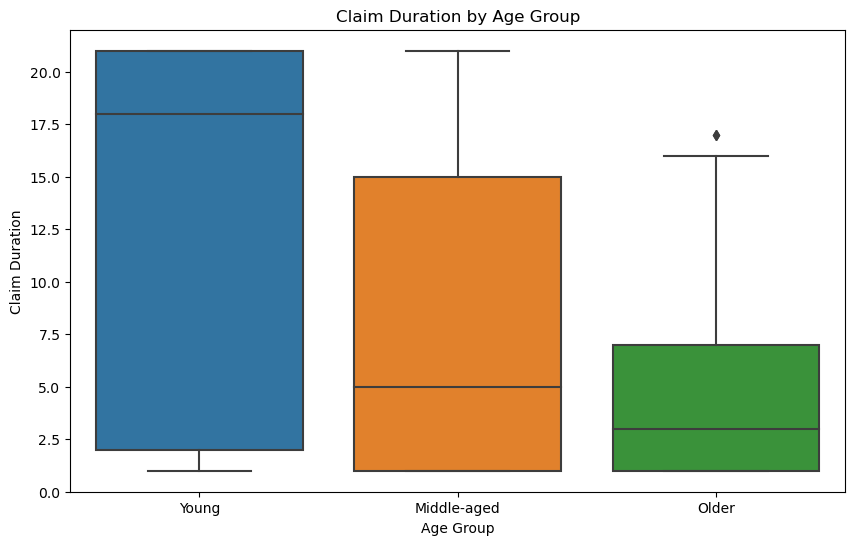

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create age groups
bins = [0, 30, 50, 70]  # Adjust the age bins as needed
labels = ['Young', 'Middle-aged', 'Older']
allianz_df['Age_Group'] = pd.cut(allianz_df['Age_At_Claim'], bins=bins, labels=labels)

# Boxplot for claim duration vs age group
plt.figure(figsize=(10, 6))
sns.boxplot(data=allianz_df, x='Age_Group', y='Duration')
plt.title('Claim Duration by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Claim Duration')
plt.show()

d:\anaconda3\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


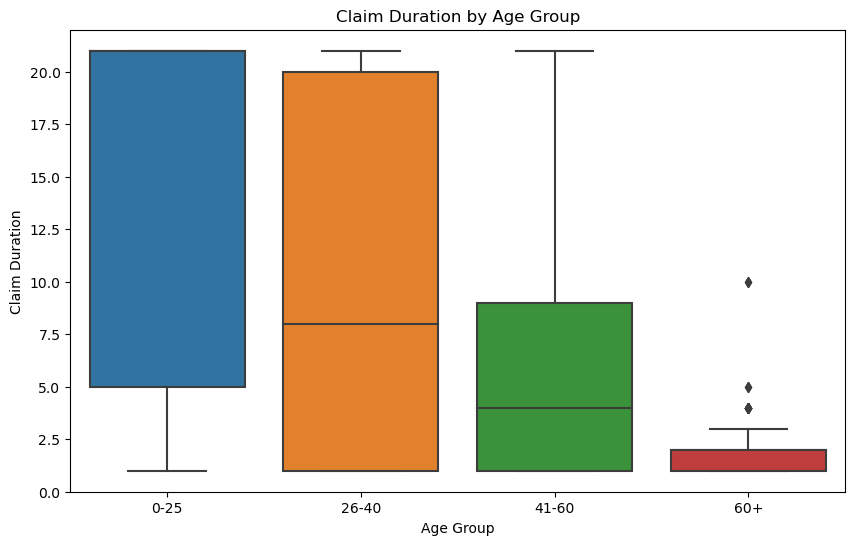

In [21]:
# Create age groups
bins = [0, 25, 40, 60, 100]  # Adjust the age bins as needed
labels = ['0-25', '26-40', '41-60', '60+']
allianz_df['Age_Group'] = pd.cut(allianz_df['Age_At_Claim'], bins=bins, labels=labels)

# Boxplot for claim duration vs age group
plt.figure(figsize=(10, 6))
sns.boxplot(data=allianz_df, x='Age_Group', y='Duration')
plt.title('Claim Duration by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Claim Duration')
plt.show()

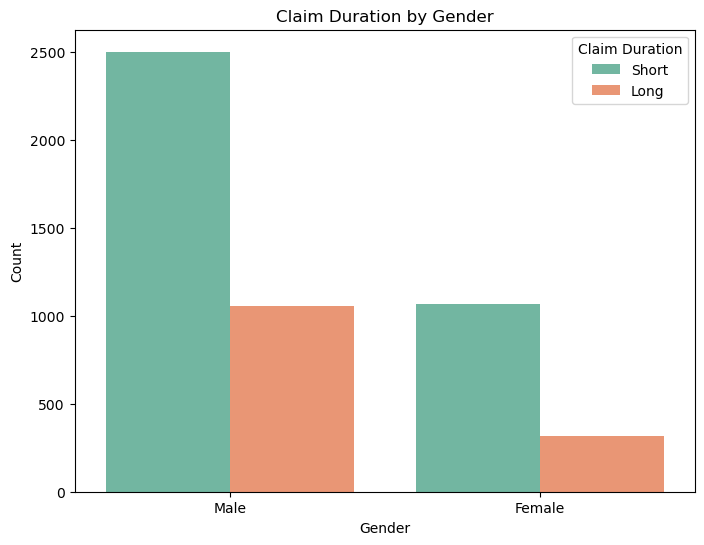

In [22]:
# Bar chart to compare the proportion of long-duration claims by Gender
plt.figure(figsize=(8, 6))
sns.countplot(data=allianz_df, x='Sex', hue='Claim_Category', palette='Set2')
plt.title('Claim Duration by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks([0, 1], ['Male', 'Female'])
plt.legend(title='Claim Duration', labels=['Short', 'Long'])
plt.show()

Percentage of Long-Duration Claims by Gender:
Sex
1    29.684862
2    23.049133
Name: 1, dtype: float64


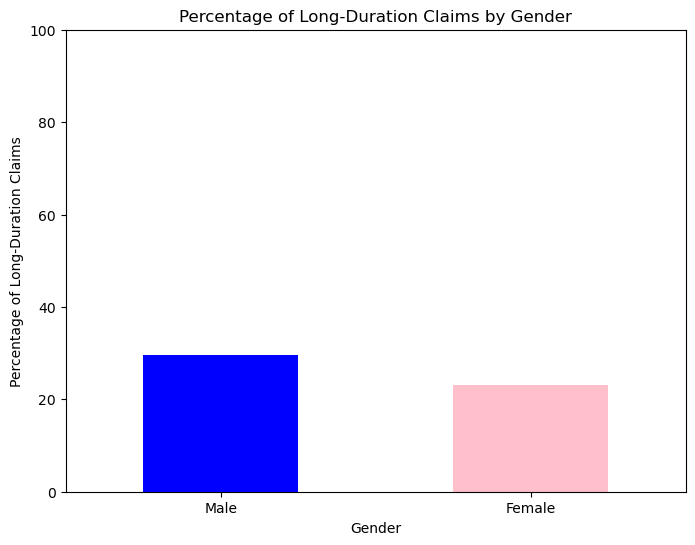

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the proportion of long-duration claims for each gender
gender_long_claims = (
    allianz_df.groupby('Sex')['Claim_Category']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

# Extract percentage of long claims (Claim_Category = 1 for long claims)
gender_long_claims_percentage = gender_long_claims[1] * 100  # Multiply by 100 for percentage

# Print the percentages for exact comparison
print("Percentage of Long-Duration Claims by Gender:")
print(gender_long_claims_percentage)

# Plot the percentage bar chart
plt.figure(figsize=(8, 6))
gender_long_claims_percentage.plot(kind='bar', color=['blue', 'pink'])
plt.title('Percentage of Long-Duration Claims by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage of Long-Duration Claims')
plt.xticks([0, 1], ['Male', 'Female'], rotation=0)
plt.ylim(0, 100)  # Percentage range
plt.show()

Percentage of Long-Duration Claims by District:
District
Antwerpen          22.142857
Brabant Wallon     30.882353
Brussels           31.250000
Hainaut            30.717863
Liege              24.133811
Limburg            20.805369
Luxembourg         29.184549
Namur              32.462687
Oost-Vlaanderen    33.878505
Vlaams Brabant     35.000000
West-Vlaanderen    29.943503
Name: 1, dtype: float64


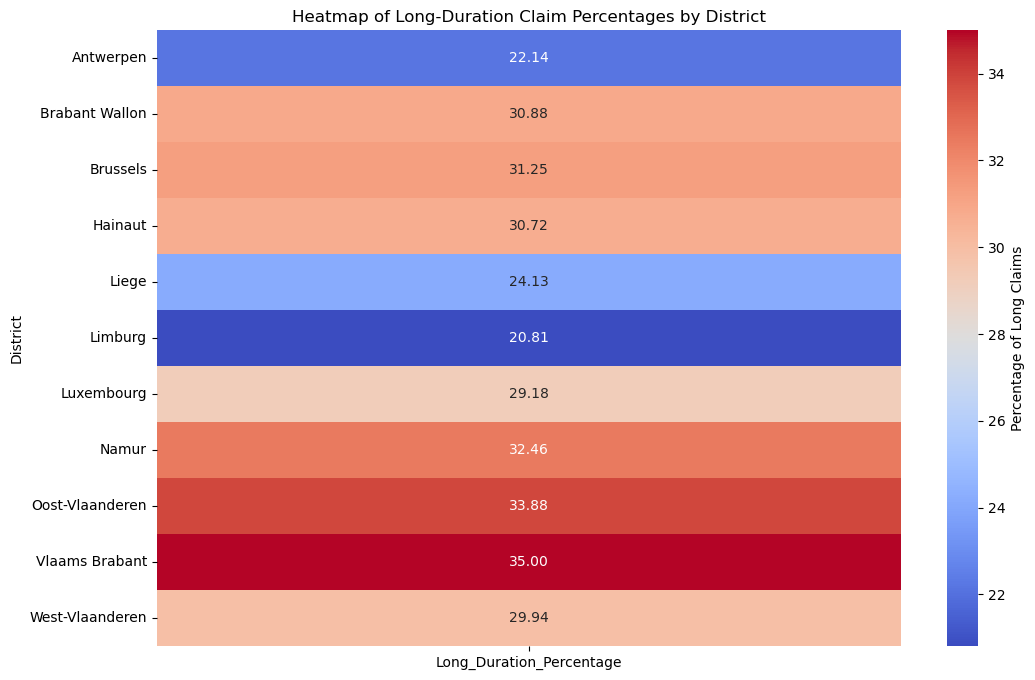

In [24]:
 # If working with geographical data

# Calculate the percentage of long-duration claims by district
district_long_claims = (
    allianz_df.groupby('District')['Claim_Category']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
)

# Extract percentage of long claims (Claim_Category = 1)
district_long_claims_percentage = district_long_claims[1] * 100

# Print the percentages for each district
print("Percentage of Long-Duration Claims by District:")
print(district_long_claims_percentage)

# Prepare data for heatmap visualization
districts_data = district_long_claims_percentage.reset_index()
districts_data.columns = ['District', 'Long_Duration_Percentage']

# Plot the heatmap (assuming 'District' column can be mapped geographically)
plt.figure(figsize=(12, 8))
sns.heatmap(
    data=districts_data.set_index('District'),
    annot=True,
    cmap='coolwarm',
    cbar_kws={'label': 'Percentage of Long Claims'},
    fmt='.2f',
)
plt.title('Heatmap of Long-Duration Claim Percentages by District')
plt.ylabel('District')
plt.xlabel('')  # Remove xlabel for cleaner visualization
plt.show()

In [25]:
# Calculate the number of long-duration claims for each broker
broker_long_claims_count = (
    allianz_df[allianz_df['Claim_Category'] == 1]
    .groupby('Broker')['Claim_Category']
    .count()
)

# Calculate the total number of claims for each broker
broker_total_claims = allianz_df.groupby('Broker')['Claim_Category'].count()

# Calculate the percentage of long-duration claims for each broker
broker_long_claims_percentage = (broker_long_claims_count / broker_total_claims) * 100

# Combine the counts and percentages into a single DataFrame for better display
broker_analysis = pd.DataFrame({
    'Long_Duration_Claims_Count': broker_long_claims_count,
    'Total_Claims': broker_total_claims,
    'Long_Duration_Percentage': broker_long_claims_percentage
}).fillna(0).sort_values(by='Long_Duration_Percentage', ascending=False)

# Print the analysis
print("Long-Duration Claims Analysis by Broker:")
print(broker_analysis)

Long-Duration Claims Analysis by Broker:
            Long_Duration_Claims_Count  Total_Claims  Long_Duration_Percentage
Broker                                                                        
51072827.0                         2.0             2                     100.0
35401827.0                         1.0             1                     100.0
36936199.0                         2.0             2                     100.0
81442461.0                         3.0             3                     100.0
36340774.0                         1.0             1                     100.0
...                                ...           ...                       ...
44917920.0                         0.0             1                       0.0
45333378.0                         0.0             1                       0.0
45588280.0                         0.0             2                       0.0
45658495.0                         0.0            16                       0.0
99980375.0 

            total_claims  long_claims  long_claim_percentage
Broker                                                      
80977513.0            12            9              75.000000
87183344.0            10            7              70.000000
84812674.0            13            9              69.230769
8157676.0             11            7              63.636364
302029.0              18           10              55.555556
...                  ...          ...                    ...
9346475.0             22            0               0.000000
36047451.0            11            0               0.000000
15198327.0            12            0               0.000000
45658495.0            16            0               0.000000
86478229.0            10            0               0.000000

[107 rows x 3 columns]


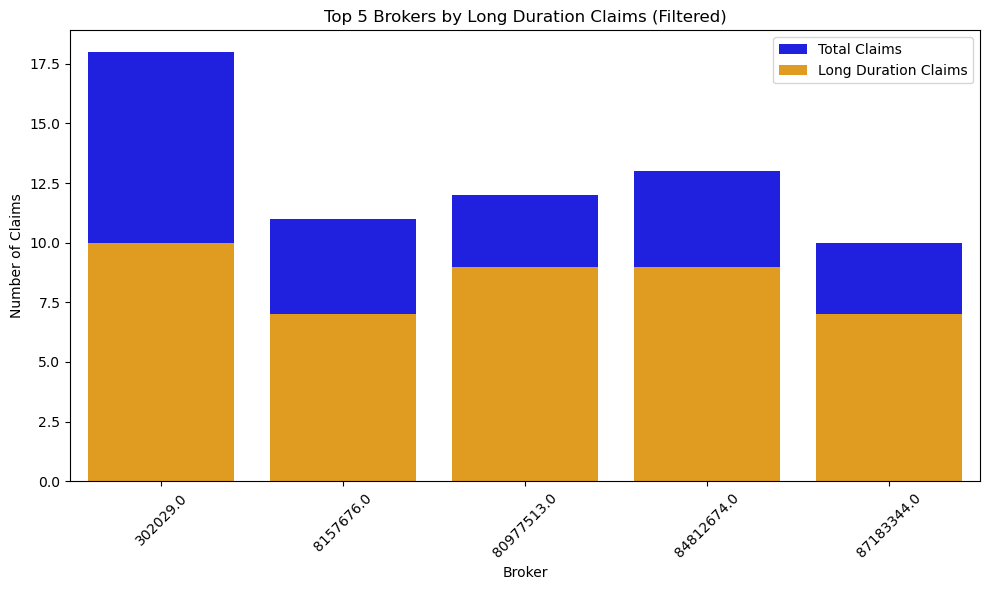

In [26]:
# Calculate total claims and percentage of long-duration claims for each broker
broker_stats = allianz_df.groupby('Broker').agg(
    total_claims=('Claim_Category', 'count'),
    long_claims=('Claim_Category', lambda x: (x == 1).sum())
)

# Calculate percentage of long-duration claims
broker_stats['long_claim_percentage'] = (broker_stats['long_claims'] / broker_stats['total_claims']) * 100

# Apply a threshold: Consider brokers with at least 10 total claims
broker_stats_filtered = broker_stats[broker_stats['total_claims'] >= 10]

# Sort by percentage of long-duration claims
broker_stats_filtered = broker_stats_filtered.sort_values(by='long_claim_percentage', ascending=False)

# Print the updated broker statistics
print(broker_stats_filtered)

# Visualize the top 5 brokers after applying the threshold
top_5_brokers = broker_stats_filtered.head(5)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_5_brokers.reset_index(),
    x='Broker',
    y='total_claims',
    color='blue',
    label='Total Claims'
)
sns.barplot(
    data=top_5_brokers.reset_index(),
    x='Broker',
    y='long_claims',
    color='orange',
    label='Long Duration Claims'
)
plt.title('Top 5 Brokers by Long Duration Claims (Filtered)')
plt.xlabel('Broker')
plt.ylabel('Number of Claims')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [27]:
# Identify brokers with 100% long-duration claims
brokers_100_percent = broker_stats[broker_stats['long_claim_percentage'] == 100]

# Print brokers with 100% long-duration claims
print("Brokers with 100% long-duration claims (including those with low total claims):")
print(brokers_100_percent)

Brokers with 100% long-duration claims (including those with low total claims):
            total_claims  long_claims  long_claim_percentage
Broker                                                      
1127003.0              2            2                  100.0
2252964.0              1            1                  100.0
2323473.0              1            1                  100.0
2772615.0              1            1                  100.0
2946542.0              1            1                  100.0
...                  ...          ...                    ...
98433599.0             1            1                  100.0
98790371.0             1            1                  100.0
99172206.0             1            1                  100.0
99414320.0             1            1                  100.0
99755362.0             1            1                  100.0

[276 rows x 3 columns]


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

#Calculate total claims, long-duration claims, and short claims for each broker
broker_analysis = (
    allianz_df.groupby('Broker')['Claim_Category']
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={0: 'Short_Claims', 1: 'Long_Claims'})
)
broker_analysis['Total_Claims'] = broker_analysis['Short_Claims'] + broker_analysis['Long_Claims']

#Add a column for short claim percentages
broker_analysis['Short_Claim_Percentage'] = (
    broker_analysis['Short_Claims'] / broker_analysis['Total_Claims'] * 100
)

#Identify top brokers by total claims and performance
top_brokers_by_volume = broker_analysis.sort_values('Total_Claims', ascending=False).head(10)
top_brokers_by_performance = top_brokers_by_volume.sort_values('Short_Claim_Percentage', ascending=False)

#Print the detailed data
print("Top Brokers by Volume and Short Claim Performance:\n")
print(top_brokers_by_performance)

Top Brokers by Volume and Short Claim Performance:

Claim_Category  Short_Claims  Long_Claims  Total_Claims  \
Broker                                                    
5614684.0                 62            6            68   
32704839.0                76           12            88   
84457806.0                45            8            53   
61603288.0                59           11            70   
60246561.0                31            9            40   
93602112.0                29           12            41   
21206979.0                43           18            61   
71731179.0                50           28            78   
79779951.0                47           29            76   
70075182.0                46           42            88   

Claim_Category  Short_Claim_Percentage  
Broker                                  
5614684.0                    91.176471  
32704839.0                   86.363636  
84457806.0                   84.905660  
61603288.0                   84.28

In [29]:
allianz_df.columns

Index(['Contract_number', 'Sex', 'Birth_year', 'Birth_month', 'End_age',
       'Claim_year', 'Claim_month', 'Pct_dis1', 'Pct_dis2', 'Pct_dis3',
       'Pct_dis4', 'Pct_dis5', 'Pct_dis6', 'Pct_dis7', 'Pct_dis8', 'Pct_dis9',
       'Pct_dis10', 'Pct_dis11', 'Pct_dis12', 'Pct_dis13', 'Pct_dis14',
       'Pct_dis15', 'Pct_dis16', 'Pct_dis17', 'Pct_dis18', 'Pct_dis19',
       'Pct_dis20', 'Pct_dis21', 'Duration', 'Postalcode', 'District',
       'Broker', 'Annuity', 'Birth_Date', 'Claim_Date', 'Age_At_Claim',
       'Claim_Category', 'Age_Group'],
      dtype='object')

In [30]:
# Drop the specified columns
columns_to_drop = ['Birth_year', 'Birth_month', 'End_age', 'Claim_year', 'Claim_month', 'Birth_Date', 'Claim_Date']
allianz_df.drop(columns=columns_to_drop, inplace=True)

# Display the remaining columns to confirm
print(allianz_df.columns)

Index(['Contract_number', 'Sex', 'Pct_dis1', 'Pct_dis2', 'Pct_dis3',
       'Pct_dis4', 'Pct_dis5', 'Pct_dis6', 'Pct_dis7', 'Pct_dis8', 'Pct_dis9',
       'Pct_dis10', 'Pct_dis11', 'Pct_dis12', 'Pct_dis13', 'Pct_dis14',
       'Pct_dis15', 'Pct_dis16', 'Pct_dis17', 'Pct_dis18', 'Pct_dis19',
       'Pct_dis20', 'Pct_dis21', 'Duration', 'Postalcode', 'District',
       'Broker', 'Annuity', 'Age_At_Claim', 'Claim_Category', 'Age_Group'],
      dtype='object')


In [31]:
# Calculate the sum of all disability ratios for each record
allianz_df['Disability_Sum'] = allianz_df.loc[:, 'Pct_dis1':'Pct_dis21'].sum(axis=1)

# Display a preview of the new column
print(allianz_df[['Duration', 'Disability_Sum']].head(50))

    Duration  Disability_Sum
3         10            9.50
4          1            1.00
5          4            3.50
6          1            0.80
7          3            2.80
9          3            3.00
13         2            1.00
14         1            1.00
15         3            2.50
16         1            0.25
17         1            0.25
19         4            4.00
20         1            1.00
21         1            0.50
22         1            1.00
23         7            7.00
24         7            7.00
26         1            1.00
27         1            1.00
28         2            2.00
29         1            0.25
30         1            0.25
34         1            0.50
35         2            1.80
36         1            0.80
38         2            2.00
41         1            0.80
43         1            1.00
44         1            0.25
45         1            1.00
46         1            1.00
47         1            0.80
48         1            1.00
49         2  

In [32]:
# Sort the DataFrame by 'Duration' in descending order
sorted_allianz_df = allianz_df.sort_values(by='Duration', ascending=False)

# Display the top rows of the sorted DataFrame
print(sorted_allianz_df[['Duration', 'Disability_Sum']].head(50))

      Duration  Disability_Sum
555         21           21.00
3425        21           21.00
3419        21           21.00
608         21           21.00
2187        21           10.50
2472        21           20.50
576         21           21.00
2196        21           21.00
3737        21           21.00
2468        21           19.50
3422        21           21.00
4286        21           21.00
4285        21           20.20
3151        21           20.50
577         21           20.55
3741        21           21.00
968         21           20.80
2119        21           19.98
3473        21           21.00
3158        21           21.00
2446        21           21.00
2443        21           21.00
604         21           21.00
3780        21           21.00
1234        21           19.98
4209        21           21.00
3801        21           19.50
3467        21           19.50
406         21           21.00
2711        21           20.05
921         21           21.00
3809    

In [33]:
# Sort by 'Duration' first and then by 'Disability_Sum'
sorted_allianz_df = allianz_df.sort_values(by=['Duration', 'Disability_Sum'], ascending=[False, True])

# Display the top rows
print(sorted_allianz_df[['Duration', 'Disability_Sum']].head(10))

      Duration  Disability_Sum
3209        21            9.03
2187        21           10.50
3507        21           11.55
2258        21           12.30
2383        21           15.00
2010        21           16.80
3695        21           17.40
833         21           19.50
1008        21           19.50
1979        21           19.50


In [34]:
allianz_df.columns

Index(['Contract_number', 'Sex', 'Pct_dis1', 'Pct_dis2', 'Pct_dis3',
       'Pct_dis4', 'Pct_dis5', 'Pct_dis6', 'Pct_dis7', 'Pct_dis8', 'Pct_dis9',
       'Pct_dis10', 'Pct_dis11', 'Pct_dis12', 'Pct_dis13', 'Pct_dis14',
       'Pct_dis15', 'Pct_dis16', 'Pct_dis17', 'Pct_dis18', 'Pct_dis19',
       'Pct_dis20', 'Pct_dis21', 'Duration', 'Postalcode', 'District',
       'Broker', 'Annuity', 'Age_At_Claim', 'Claim_Category', 'Age_Group',
       'Disability_Sum'],
      dtype='object')

In [35]:
# Calculate the total amount owed
allianz_df['total_amount_owed'] = allianz_df['Disability_Sum'] * allianz_df['Annuity']

# Display the first few rows to verify
print(allianz_df[['Disability_Sum', 'Annuity', 'total_amount_owed']].head())

   Disability_Sum     Annuity  total_amount_owed
3             9.5  9785032.00       9.295780e+07
4             1.0    34345.63       3.434563e+04
5             3.5     6544.40       2.290540e+04
6             0.8    25636.86       2.050949e+04
7             2.8     3576.28       1.001358e+04


In [36]:
allianz_df.columns

Index(['Contract_number', 'Sex', 'Pct_dis1', 'Pct_dis2', 'Pct_dis3',
       'Pct_dis4', 'Pct_dis5', 'Pct_dis6', 'Pct_dis7', 'Pct_dis8', 'Pct_dis9',
       'Pct_dis10', 'Pct_dis11', 'Pct_dis12', 'Pct_dis13', 'Pct_dis14',
       'Pct_dis15', 'Pct_dis16', 'Pct_dis17', 'Pct_dis18', 'Pct_dis19',
       'Pct_dis20', 'Pct_dis21', 'Duration', 'Postalcode', 'District',
       'Broker', 'Annuity', 'Age_At_Claim', 'Claim_Category', 'Age_Group',
       'Disability_Sum', 'total_amount_owed'],
      dtype='object')

In [37]:
# Select the desired columns and create a new DataFrame
v1_df = allianz_df[['total_amount_owed', 'Duration']]
#v3_df=allianz_df[['Age_At_Claim', 'Duration', 'Disability_Sum_Per_Year', 'Annuity','total_amount_owed']]
# Display the first few rows to verify
print(v1_df.head())

   total_amount_owed  Duration
3       9.295780e+07        10
4       3.434563e+04         1
5       2.290540e+04         4
6       2.050949e+04         1
7       1.001358e+04         3


In [38]:
v1_df.dtypes

total_amount_owed    float64
Duration               int64
dtype: object

In [39]:
v1_df_norm=(v1_df-v1_df.mean())/v1_df.std()

In [40]:
v1_df_norm.head()

,total_amount_owed,Duration
3,-0.345811,0.553180
4,-0.348983,-0.872997
5,-0.348983,-0.397604
6,-0.348983,-0.872997
7,-0.348983,-0.556068


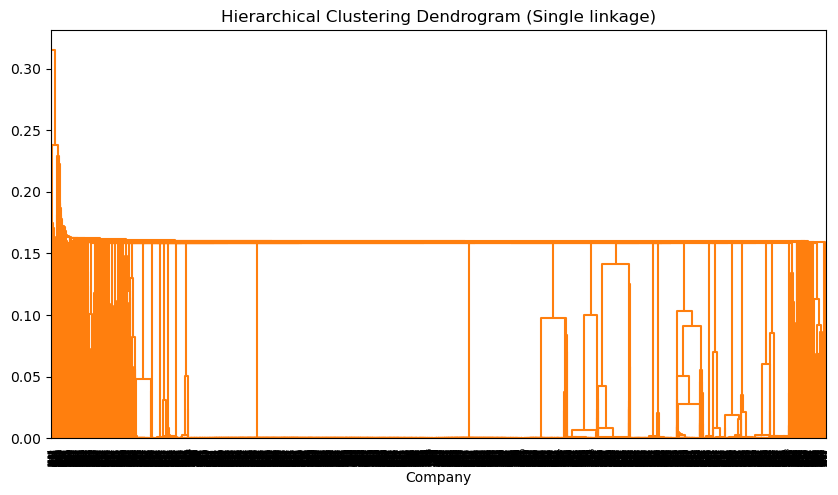

In [41]:
#Use one of the following methods: 'single', 'average','ward','complete','centroid'
Z = linkage(v1_df_norm, method='single') 

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (Single linkage)')
plt.xlabel('Company')
# 'color_threshold = 2.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (2.5), at which the agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(Z, labels=v1_df_norm.index, color_threshold=2.5)
plt.axhline(y=2.75, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

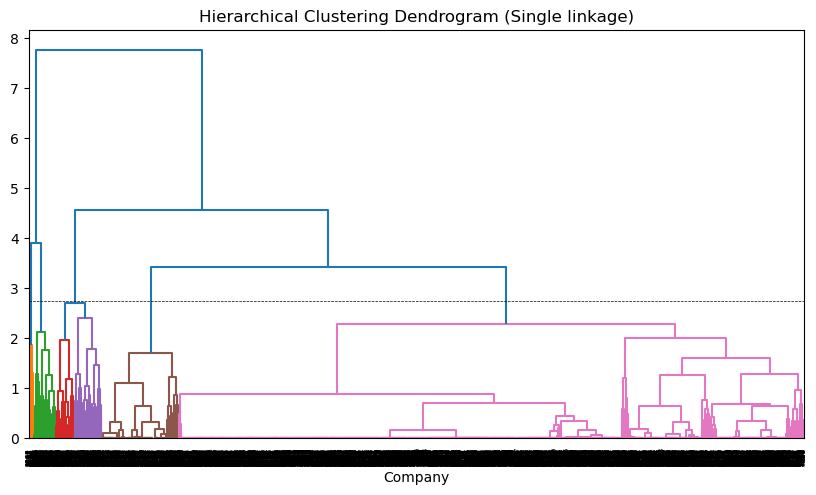

In [42]:
#Use one of the following methods: 'single', 'average','ward','complete','centroid'
Z1 = linkage(v1_df_norm, method='complete') 

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (Single linkage)')
plt.xlabel('Company')
# 'color_threshold = 2.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (2.5), at which the agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(Z1, labels=v1_df_norm.index, color_threshold=2.5)
plt.axhline(y=2.75, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

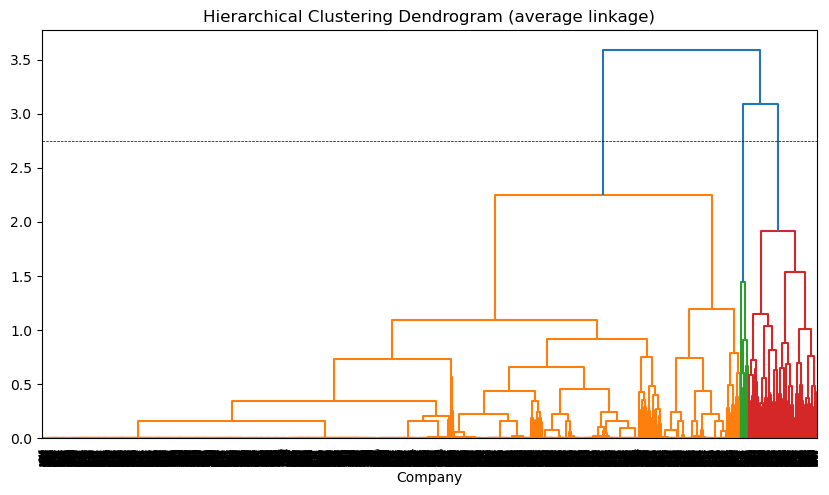

In [43]:
#Use one of the following methods: 'single', 'average','ward','complete','centroid'
Z2 = linkage(v1_df_norm, method='average') 

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (average linkage)')
plt.xlabel('Company')
# 'color_threshold = 2.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (2.5), at which the agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(Z2, labels=v1_df_norm.index, color_threshold=2.5)
plt.axhline(y=2.75, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

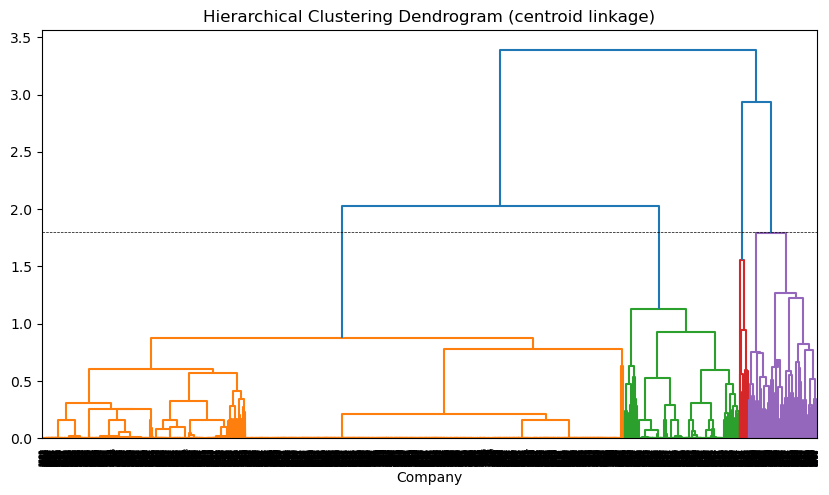

In [44]:
#Use one of the following methods: 'single', 'average','ward','complete','centroid'
Z3 = linkage(v1_df_norm, method='centroid') 

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (centroid linkage)')
plt.xlabel('Company')
# 'color_threshold = 2.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (2.5), at which the agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(Z3, labels=v1_df_norm.index, color_threshold=1.8)
plt.axhline(y=1.8, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

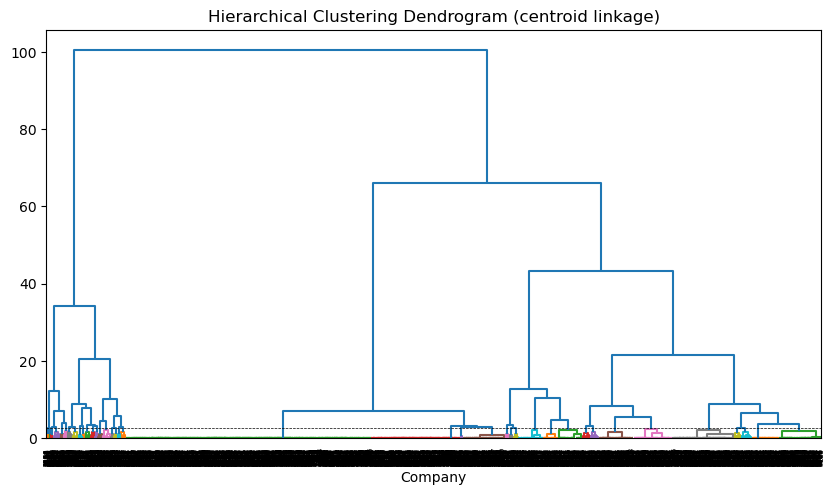

In [45]:
#Use one of the following methods: 'single', 'average','','complete','centroid'
Z4 = linkage(v1_df_norm, method='ward') 

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (centroid linkage)')
plt.xlabel('Company')
# 'color_threshold = 2.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (2.5), at which the agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(Z4, labels=v1_df_norm.index, color_threshold=2.5)
plt.axhline(y=2.75, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

In [46]:
memb = fcluster(Z3, 4, criterion='maxclust') #no more than 6 clusters
#The above variable has membership of each row. To make it presentable we reorganize next
memb = pd.Series(memb, index=v1_df_norm.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(map(str, item.index)))

1 :  3, 4, 5, 6, 7, 9, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 34, 35, 36, 38, 41, 43, 44, 45, 46, 47, 48, 49, 52, 57, 58, 60, 61, 64, 65, 68, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 139, 140, 142, 143, 147, 148, 149, 150, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 172, 173, 174, 176, 178, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 193, 195, 196, 197, 198, 199, 201, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 

In [47]:
v1_df_norm.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, v1_df_norm.index)]

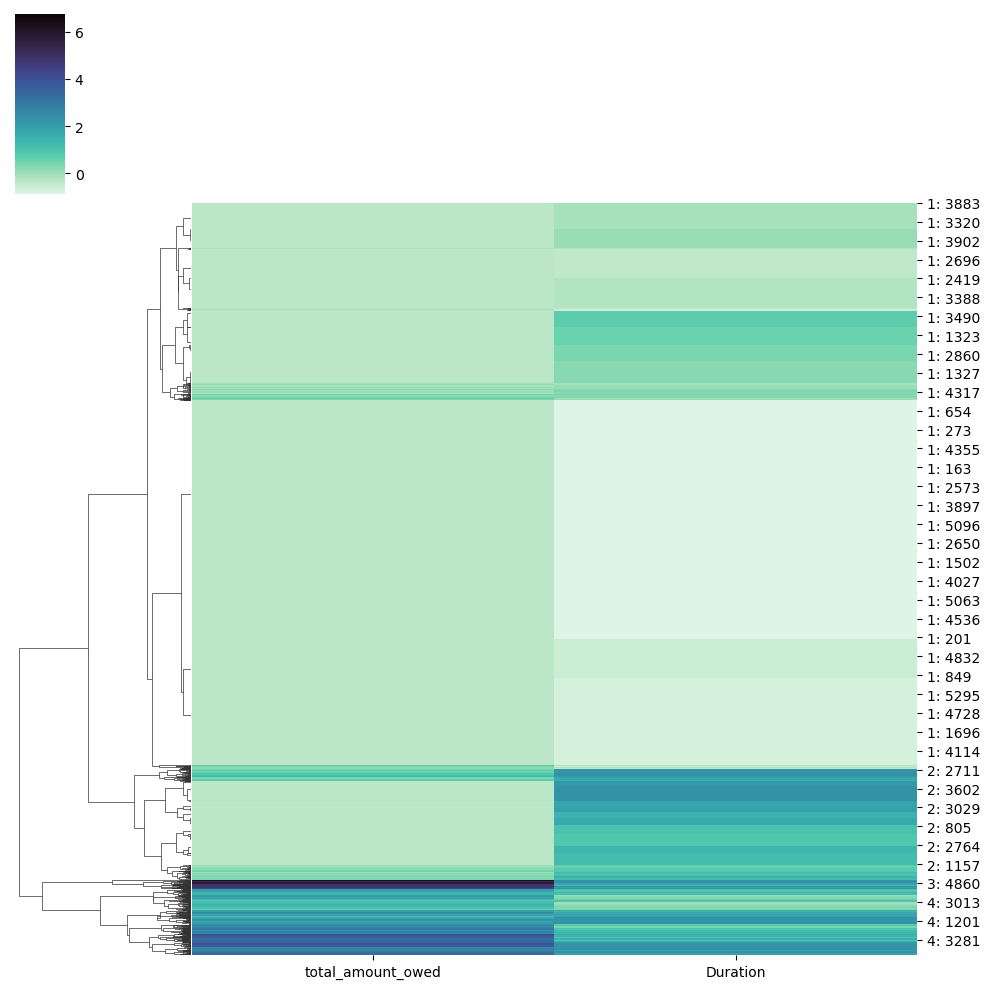

In [48]:
#Cluster map (aka Heat map)
sns.clustermap(v1_df_norm, method='centroid', col_cluster=False,  cmap="mako_r") #mako_r is a commonly used color palette for Heatmaps. 'rocket' is another common one
plt.show()

In [75]:
# Add a new column for Disability_Sum divided by 21
allianz_df['Disability_Sum_Per_Year'] = allianz_df['Disability_Sum'] / 21

# Create a new DataFrame with the specified columns
v2_df = allianz_df[['Age_At_Claim', 'Duration','Annuity']]
v2_centroid=v2_df.copy()
v2_ward=v2_df.copy()
# Display the first few rows of the new DataFrame
print(v2_df.head())
print(type(v2_centroid))

   Age_At_Claim  Duration     Annuity
3            54        10  9785032.00
4            55         1    34345.63
5            33         4     6544.40
6            31         1    25636.86
7            48         3     3576.28
<class 'pandas.core.frame.DataFrame'>


In [76]:
v2_df_norm=(v2_df-v2_df.mean())/v2_df.std()
v2_centroid_norm=(v2_centroid-v2_centroid.mean())/v2_centroid.std()
v2_ward_norm=(v2_ward-v2_ward.mean())/v2_ward.std()

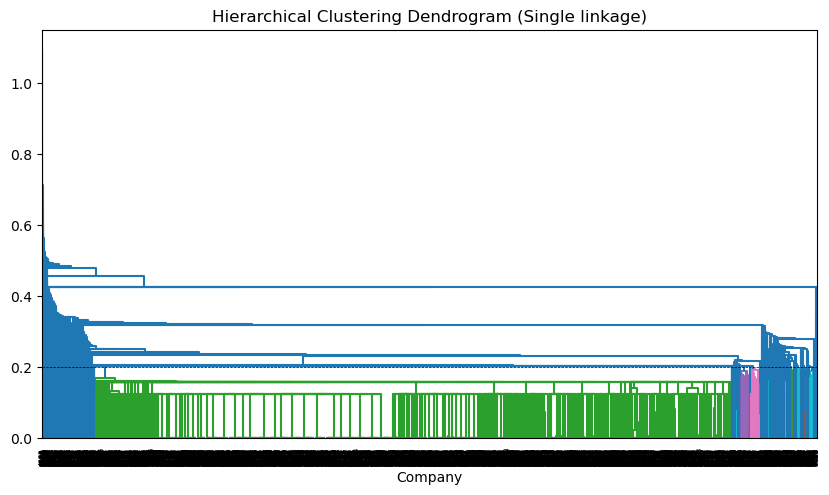

In [77]:
#Use one of the following methods: 'single', 'average','ward','complete','centroid'
Zv2 = linkage(v2_df_norm, method='single') 

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (Single linkage)')
plt.xlabel('Company')
# 'color_threshold = 2.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (2.5), at which the agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(Zv2, labels=v2_df_norm.index, color_threshold=0.2)
plt.axhline(y=0.2, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

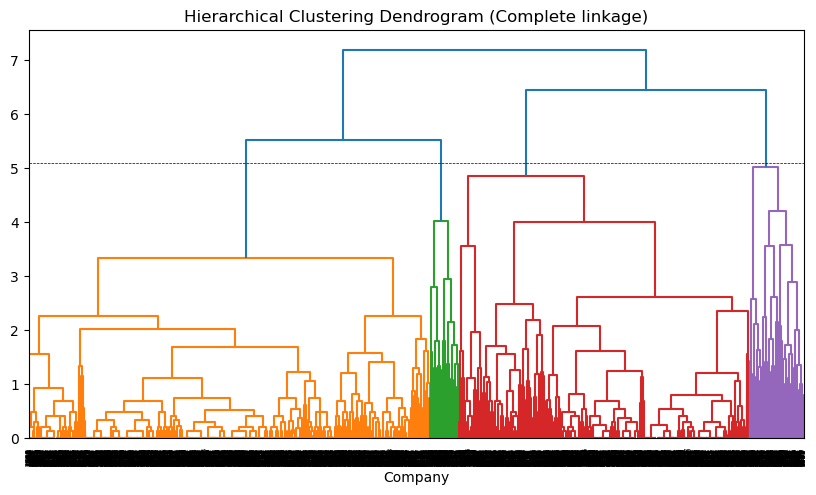

In [78]:
#Use one of the following methods: 'single', 'average','ward','complete','centroid'
Z1v2 = linkage(v2_df_norm, method='complete') 

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (Complete linkage)')
plt.xlabel('Company')
# 'color_threshold = 2.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (2.5), at which the agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(Z1v2, labels=v2_df_norm.index, color_threshold=5.1)
plt.axhline(y=5.1, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

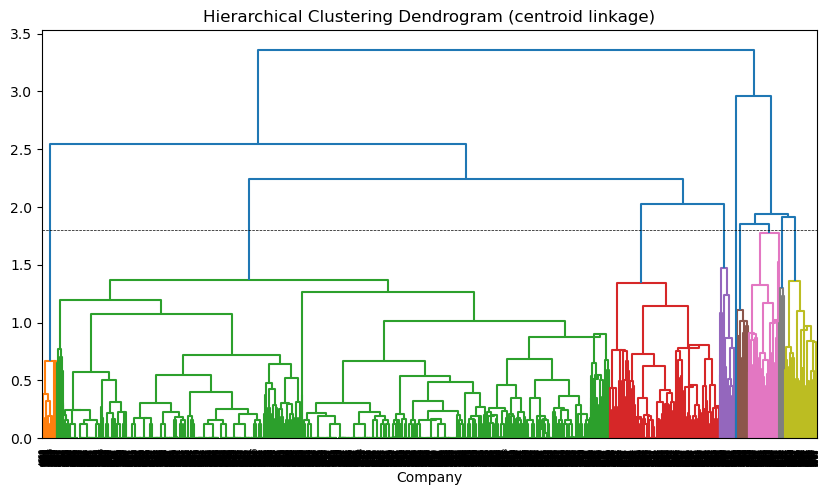

In [79]:
#Use one of the following methods: 'single', 'average','ward','complete','centroid'
Z3v2 = linkage(v2_df_norm, method='centroid') 

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (centroid linkage)')
plt.xlabel('Company')
# 'color_threshold = 2.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (2.5), at which the agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(Z3v2, labels=v2_df_norm.index, color_threshold=1.8)
plt.axhline(y=1.8, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

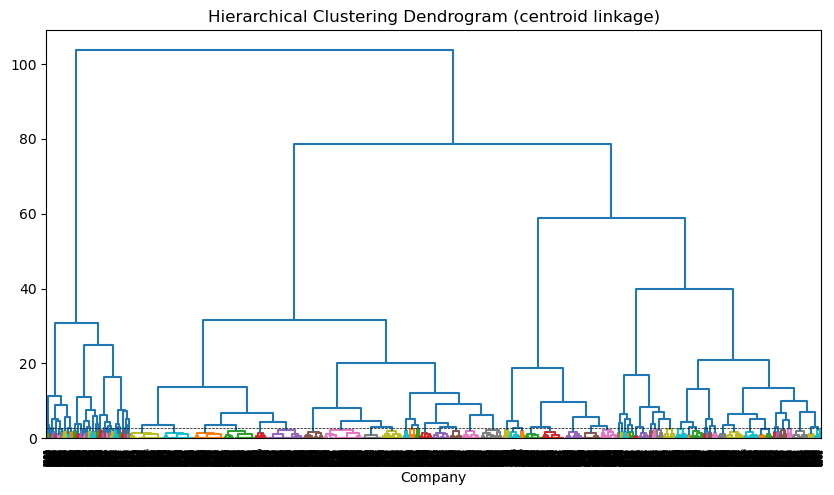

In [80]:
#Use one of the following methods: 'single', 'average','','complete','centroid'
Z4v2 = linkage(v2_df_norm, method='ward') 

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (centroid linkage)')
plt.xlabel('Company')
# 'color_threshold = 2.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (2.5), at which the agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(Z4v2, labels=v2_df_norm.index, color_threshold=2.5)
plt.axhline(y=2.75, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

In [81]:
membz1v2 = fcluster(Z1v2, 5, criterion='maxclust') #no more than 6 clusters
#The above variable has membership of each row. To make it presentable we reorganize next
membz1v2 = pd.Series(membz1v2 , index=v2_df_norm.index)
for key, item in membz1v2.groupby(membz1v2):
    print(key, ': ', ', '.join(map(str, item.index)))

1 :  3, 4, 14, 17, 19, 22, 27, 28, 36, 38, 41, 43, 44, 52, 68, 76, 78, 89, 91, 92, 97, 98, 99, 109, 110, 112, 122, 124, 129, 131, 132, 139, 147, 150, 156, 166, 179, 189, 190, 196, 197, 212, 213, 216, 224, 226, 233, 240, 241, 243, 256, 264, 266, 267, 268, 270, 275, 284, 288, 289, 295, 302, 303, 306, 307, 323, 325, 326, 327, 328, 329, 330, 331, 332, 334, 335, 336, 337, 338, 339, 340, 342, 343, 344, 345, 346, 347, 348, 350, 353, 354, 355, 356, 357, 358, 359, 365, 367, 368, 371, 372, 373, 374, 375, 377, 378, 379, 381, 382, 385, 386, 394, 395, 396, 398, 402, 403, 410, 412, 413, 414, 415, 416, 417, 419, 420, 422, 423, 424, 426, 428, 430, 431, 432, 435, 437, 438, 439, 440, 441, 444, 445, 447, 452, 453, 454, 455, 456, 457, 459, 463, 465, 466, 468, 470, 475, 479, 481, 482, 485, 488, 489, 492, 493, 494, 495, 497, 498, 499, 502, 503, 506, 509, 511, 513, 514, 516, 520, 524, 526, 528, 529, 530, 531, 533, 535, 536, 537, 538, 539, 540, 543, 544, 545, 546, 547, 548, 551, 552, 553, 554, 556, 557, 559, 

In [82]:
v2_df_norm.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(membz1v2, v2_df_norm.index)]

d:\anaconda3\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


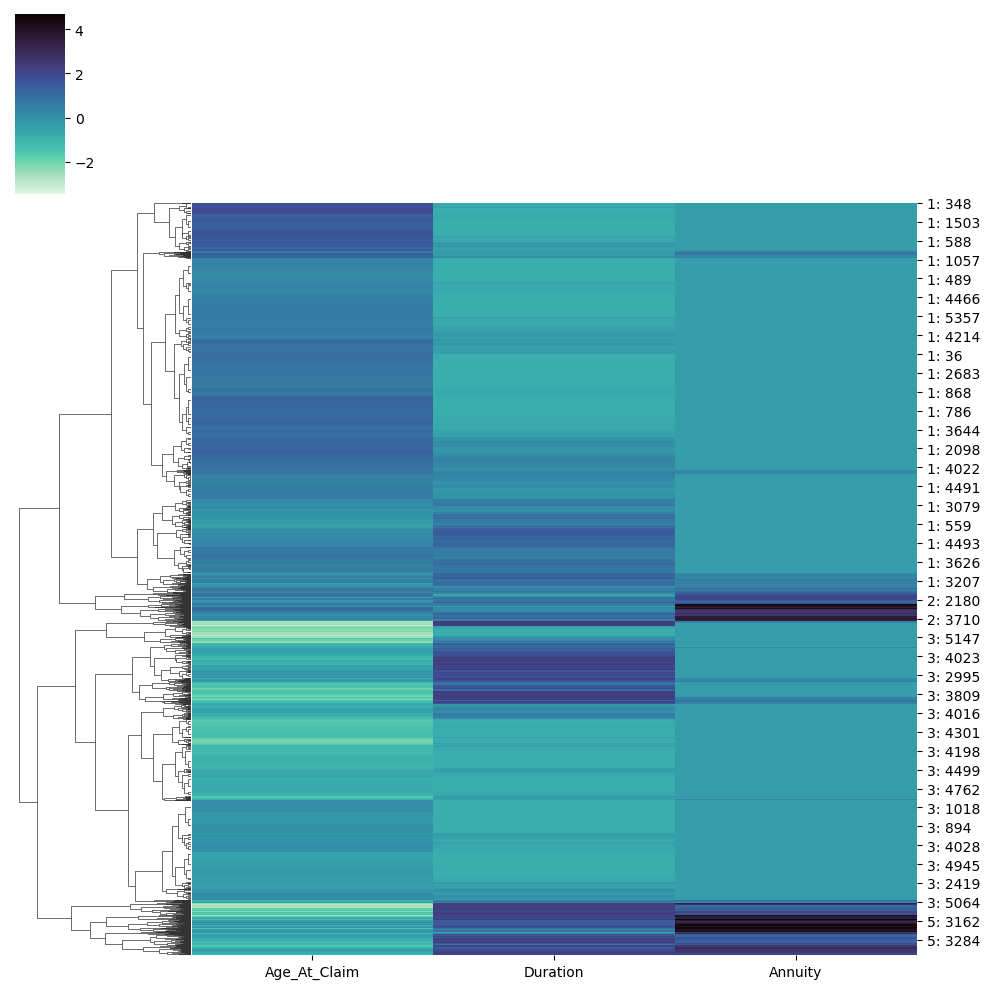

In [83]:
#Cluster map (aka Heat map)
sns.clustermap(v2_df_norm, method='complete', col_cluster=False,  cmap="mako_r") #mako_r is a commonly used color palette for Heatmaps. 'rocket' is another common one
plt.show()

In [84]:
membz3v2 = fcluster(Z3v2, 6, criterion='maxclust') #no more than 6 clusters
#The above variable has membership of each row. To make it presentable we reorganize next
membz3v2 = pd.Series(membz3v2 , index=v2_centroid_norm.index)
for key, item in membz3v2.groupby(membz3v2):
    print(key, ': ', ', '.join(map(str, item.index)))

1 :  6, 82, 105, 114, 116, 117, 136, 149, 155, 160, 173, 193, 206, 207, 222, 229, 230, 231, 237, 248, 250, 251, 252, 253, 254, 255, 257, 259, 260, 261, 263, 274, 280, 281, 287, 294, 297, 300, 305, 308, 312, 316, 317, 318, 321, 1040, 1413, 1417, 1434, 1455, 1486, 1509, 1513, 1675, 1926, 1955, 3888, 4422, 4605, 4608, 4666, 4808, 4813, 4826, 4830, 4832, 4858, 4893, 4894, 4941, 4966, 4971, 4978, 5049, 5077, 5080, 5081, 5106, 5116, 5125, 5126, 5147, 5164, 5172, 5227, 5228, 5234, 5235, 5236, 5237, 5251, 5253, 5255, 5261, 5274, 5289, 5345
2 :  3, 4, 5, 7, 9, 13, 14, 15, 16, 17, 19, 20, 21, 22, 26, 27, 28, 29, 30, 34, 35, 36, 38, 41, 43, 44, 45, 46, 47, 48, 49, 52, 57, 58, 60, 61, 64, 65, 68, 74, 75, 76, 77, 78, 80, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 110, 111, 112, 113, 118, 119, 120, 121, 122, 124, 127, 128, 129, 131, 132, 133, 134, 137, 139, 140, 142, 143, 147, 148, 150, 154, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 168, 1

In [85]:
v2_centroid_norm.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(membz3v2, v2_centroid_norm.index)]

d:\anaconda3\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


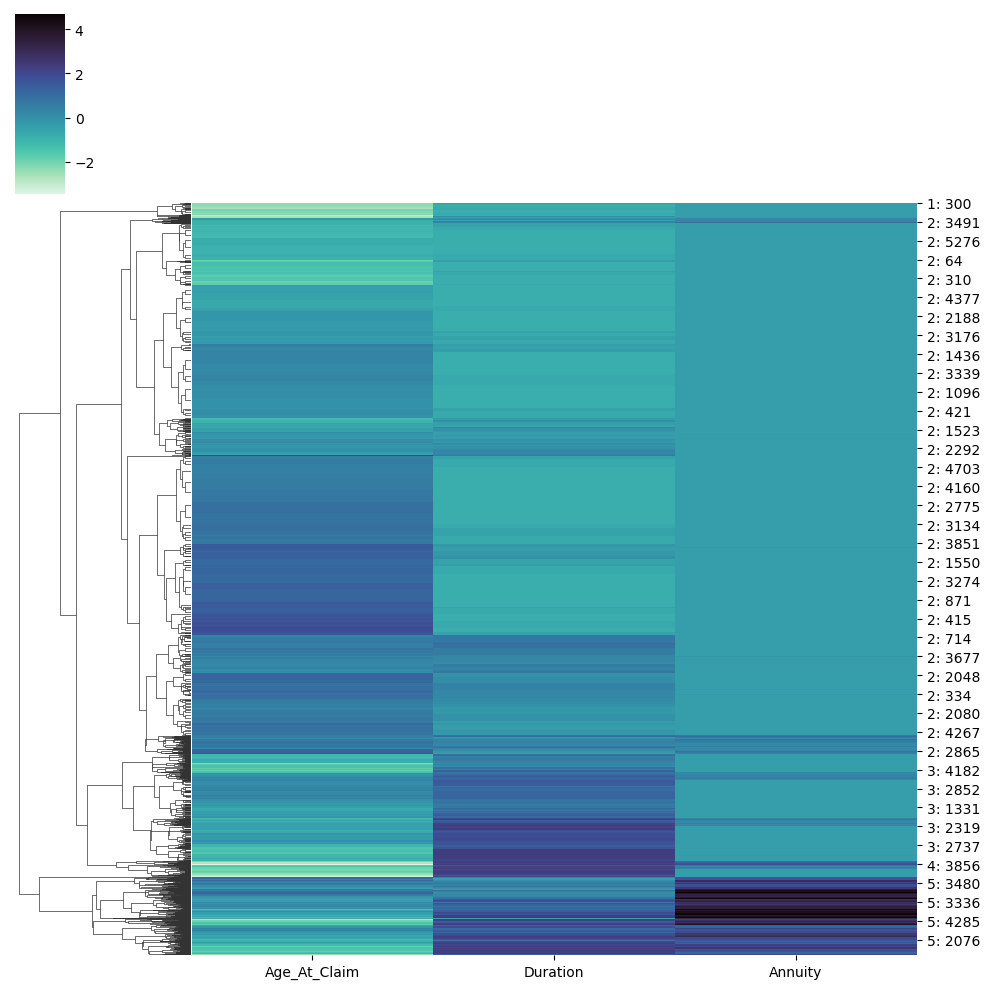

In [86]:
#Cluster map (aka Heat map)
sns.clustermap(v2_centroid_norm, method='centroid', col_cluster=False,  cmap="mako_r") #mako_r is a commonly used color palette for Heatmaps. 'rocket' is another common one
plt.show()

In [101]:
v3_df=allianz_df[['Age_At_Claim', 'Duration','Annuity','total_amount_owed']]

In [102]:
v3_df.head()
v3_complete=v3_df.copy()

In [103]:
v3_df_norm=(v3_df-v3_df.mean())/v3_df.std()

In [104]:
v3_complete_norm=(v3_complete-v3_complete.mean())/v3_complete.std()

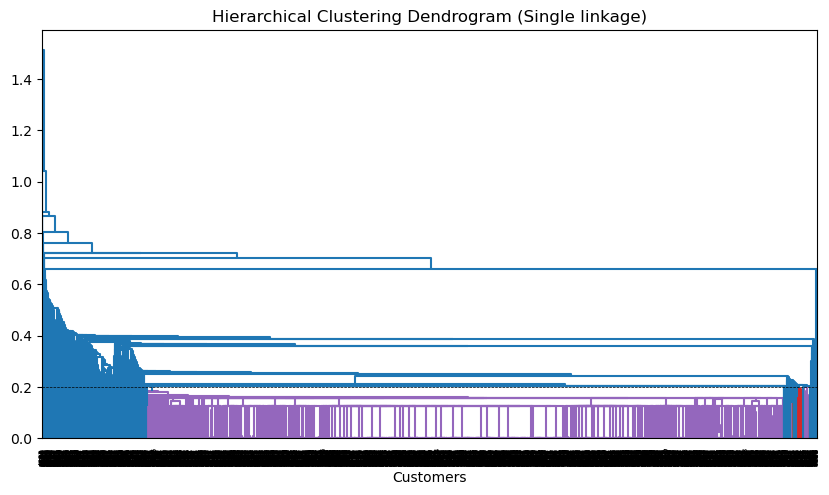

In [105]:
#Use one of the following methods: 'single', 'average','ward','complete','centroid'
Zv3 = linkage(v3_df_norm, method='single') 

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (Single linkage)')
plt.xlabel('Customers')
# 'color_threshold = 2.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (2.5), at which the agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(Zv3, labels=v3_df_norm.index, color_threshold=0.2)
plt.axhline(y=0.2, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

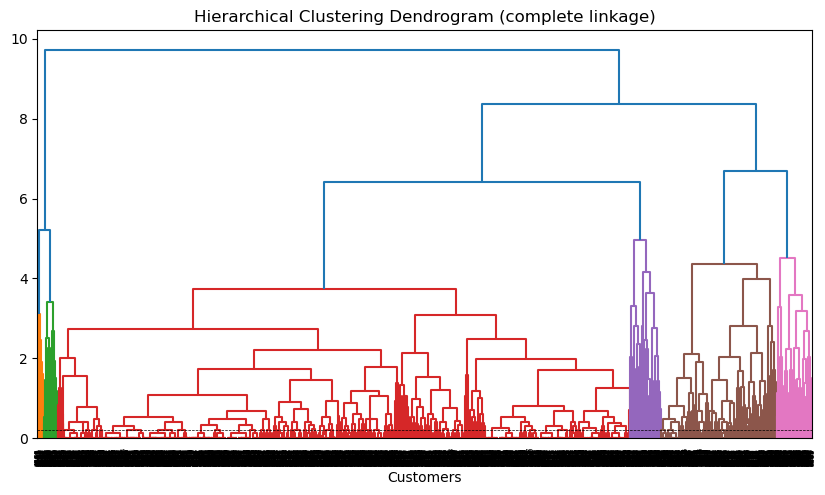

In [106]:
#Use one of the following methods: 'single', 'average','ward','complete','centroid'
Z1v3 = linkage(v3_df_norm, method='complete') 

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (complete linkage)')
plt.xlabel('Customers')
# 'color_threshold = 2.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (2.5), at which the agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(Z1v3, labels=v3_df_norm.index, color_threshold=5)
plt.axhline(y=0.2, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

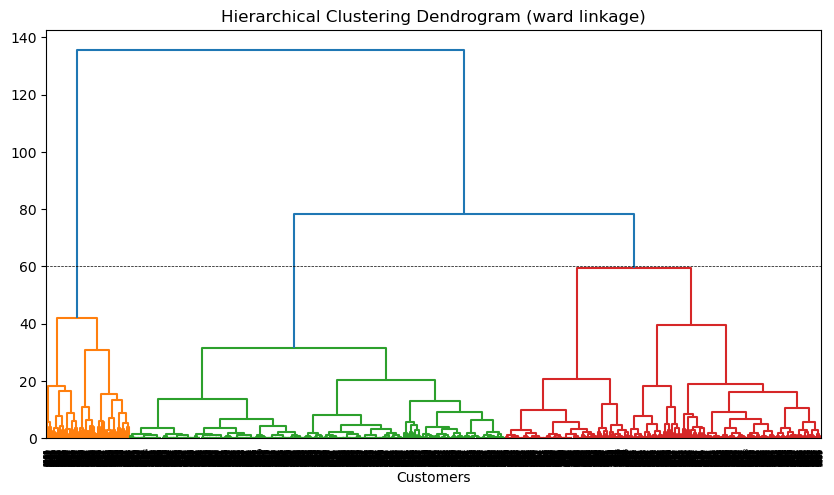

In [107]:
#Use one of the following methods: 'single', 'average','ward','complete','centroid'
Z2v3 = linkage(v3_df_norm, method='ward') 

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (ward linkage)')
plt.xlabel('Customers')
# 'color_threshold = 2.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (2.5), at which the agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(Z2v3, labels=v3_df_norm.index, color_threshold=60)
plt.axhline(y=60, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

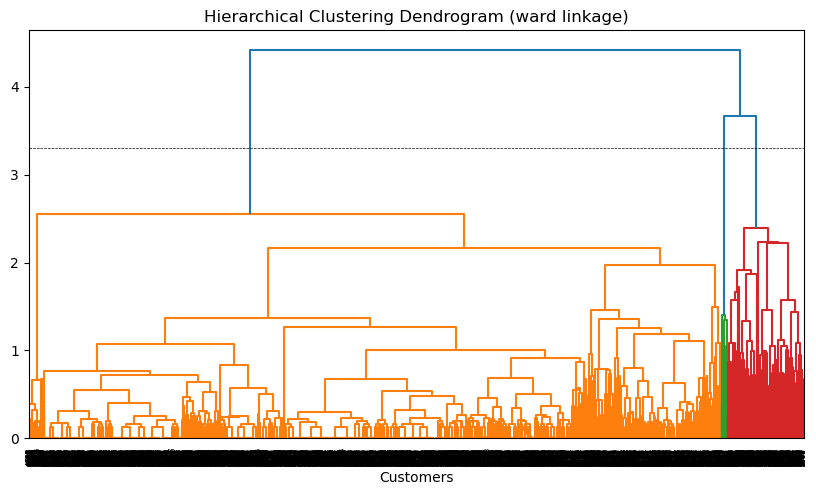

In [108]:
#Use one of the following methods: 'single', 'average','ward','complete','centroid'
Z3v3 = linkage(v3_df_norm, method='centroid') 

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.2)
plt.title('Hierarchical Clustering Dendrogram (ward linkage)')
plt.xlabel('Customers')
# 'color_threshold = 2.5' represents the threthold of cluster development. 
# It is a normalized dinstance between clusters (2.5), at which the agglomeration of records into clusters will stop. 
# The higher this value, the less clusters will be created. 
dendrogram(Z3v3, labels=v3_df_norm.index, color_threshold=3.3)
plt.axhline(y=3.3, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

In [109]:
membZ2v3 = fcluster(Z2v3, 4, criterion='maxclust') #no more than 6 clusters
#The above variable has membership of each row. To make it presentable we reorganize next
membZ2v3 = pd.Series(membZ2v3, index=v3_df_norm.index)
for key, item in membZ2v3.groupby(membZ2v3):
    print(key, ': ', ', '.join(map(str, item.index)))

1 :  145, 333, 349, 351, 360, 361, 363, 367, 376, 380, 388, 391, 397, 399, 400, 401, 405, 407, 408, 411, 427, 433, 434, 436, 443, 446, 449, 462, 469, 477, 480, 483, 487, 490, 491, 507, 523, 527, 534, 541, 549, 558, 574, 579, 580, 587, 592, 599, 608, 637, 638, 651, 662, 676, 684, 690, 695, 702, 703, 705, 706, 720, 723, 732, 736, 745, 748, 750, 756, 768, 774, 787, 791, 798, 803, 806, 819, 823, 835, 840, 860, 876, 877, 880, 885, 889, 890, 901, 902, 905, 906, 920, 922, 927, 949, 951, 962, 978, 981, 1001, 1008, 1024, 1041, 1059, 1065, 1077, 1085, 1095, 1118, 1161, 1175, 1200, 1201, 1202, 1203, 1206, 1223, 1228, 1229, 1234, 1240, 1241, 1248, 1280, 1308, 1309, 1310, 1333, 1337, 1353, 1364, 1369, 1371, 1394, 1395, 1428, 1476, 1482, 1483, 1694, 1933, 1942, 1947, 1962, 1964, 1974, 1979, 1987, 1989, 1994, 1997, 2006, 2015, 2016, 2024, 2026, 2027, 2029, 2033, 2036, 2040, 2043, 2044, 2052, 2055, 2073, 2076, 2088, 2101, 2110, 2111, 2117, 2119, 2131, 2132, 2134, 2138, 2139, 2145, 2147, 2165, 2180, 21

In [110]:
v3_df_norm.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(membZ2v3, v3_df_norm.index)]

d:\anaconda3\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


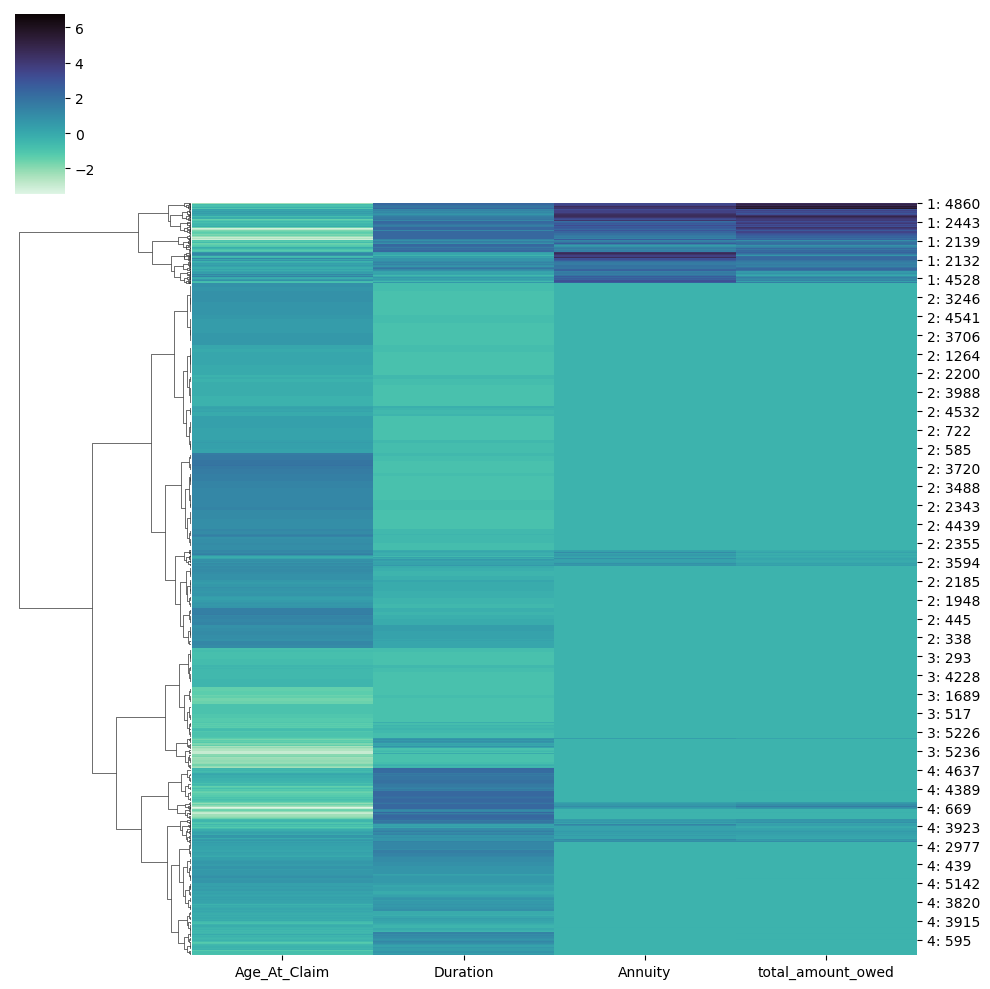

In [111]:
#Cluster map (aka Heat map)
sns.clustermap(v3_df_norm, method='ward', col_cluster=False,  cmap="mako_r") #mako_r is a commonly used color palette for Heatmaps. 'rocket' is another common one
plt.show()

In [112]:
membZ1v3 = fcluster(Z1v3, 7, criterion='maxclust') #no more than 6 clusters
#The above variable has membership of each row. To make it presentable we reorganize next
membZ1v3 = pd.Series(membZ1v3, index=v3_complete_norm.index)
for key, item in membZ1v3.groupby(membZ1v3):
    print(key, ': ', ', '.join(map(str, item.index)))

1 :  580, 732, 1008, 1077, 1202, 1234, 1333, 2015, 2290, 2297, 2341, 2410, 2426, 2568, 2606, 2787, 2920, 3147, 3257, 3262, 3265, 3317, 3357, 3375, 3418, 3492, 3511, 3523, 3534, 3543, 3554, 3737, 3887, 3979, 4001, 4019, 4246, 4286, 4497, 4738, 4860, 5023
2 :  145, 351, 380, 391, 397, 443, 449, 480, 534, 574, 637, 705, 774, 791, 840, 905, 1200, 1228, 1229, 1248, 1482, 1694, 2036, 2040, 2055, 2088, 2101, 2111, 2134, 2145, 2205, 2221, 2248, 2316, 2317, 2327, 2428, 2442, 2453, 2476, 2694, 2836, 2842, 2881, 2946, 2959, 3125, 3162, 3182, 3208, 3280, 3287, 3290, 3316, 3325, 3336, 3355, 3392, 3409, 3458, 3470, 3486, 3487, 3496, 3501, 3503, 3592, 3607, 3666, 3710, 3736, 4042, 4044, 4101, 4190, 4222, 4260, 4388, 4428, 4883, 4897, 4926, 4967, 5129, 5141, 5179, 5200, 5243, 5362
3 :  3, 4, 7, 9, 13, 14, 15, 16, 17, 19, 20, 21, 22, 26, 27, 28, 29, 30, 34, 35, 36, 38, 41, 43, 44, 45, 47, 49, 52, 57, 58, 61, 64, 65, 68, 74, 75, 76, 77, 78, 79, 80, 85, 86, 89, 91, 92, 93, 94, 97, 98, 99, 100, 101, 102, 

In [113]:
v3_complete_norm.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(membZ1v3, v3_complete_norm.index)]

d:\anaconda3\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


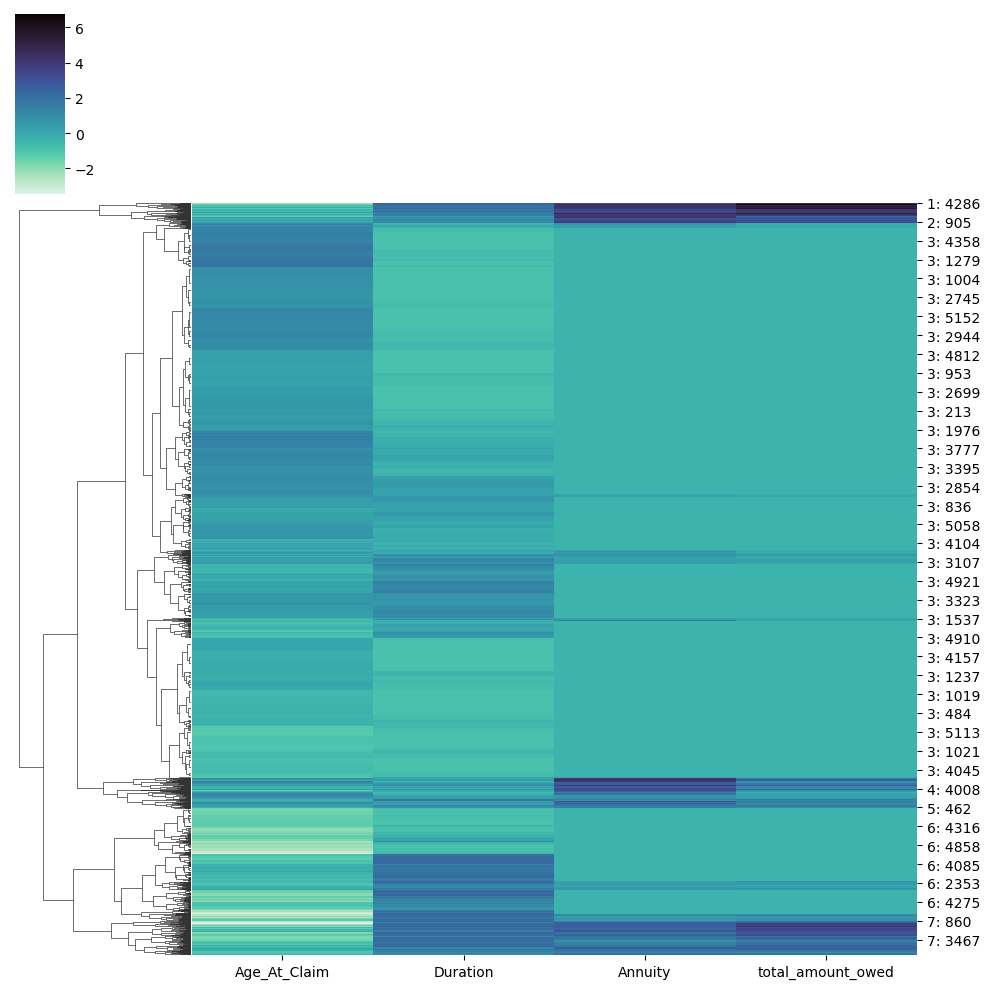

In [114]:
#Cluster map (aka Heat map)
sns.clustermap(v3_complete_norm, method='complete', col_cluster=False,  cmap="mako_r") #mako_r is a commonly used color palette for Heatmaps. 'rocket' is another common one
plt.show()